<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/03_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/03_matrix_factorization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Matrix Factorization

One apt abstraction for the ratings that users assign to items is a matrix. Most of the time, the rating matrix we observe is very sparse. The challenge then is how to fill in the missing values as accurately as possible.  If we assume that most matrices have a low-rank representation (it can be reconstructed from relatively few basis vectors), then one promising approach is to conduct matrix factorization.  Indeed, matrix factorization is a cornerstone of many recommendation algorithms.

## 1. Setup

In [1]:
!pip install --quiet cornac adjustText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 39.7 MB/s eta 0:00:00


In [2]:
import os
import sys
import itertools

import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, NMF, BaselineOnly

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Cornac version: 2.1


## 2. Low-Rank Approximation with Latent Factor Models

### Sample Data

For the purpose of illustration, we use a simple dataset involving 5 users and 6 items.

In [3]:
sample_df = pd.read_csv(
  cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"),
  sep=",", names=["UserID", "ItemID", "Rating"]
)
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
R = dataset.matrix.A
R_mask = (R > 0).astype(float)
pd.DataFrame(
  data=R,
  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)]
).replace(0, np.nan)

Data from https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv
will be cached into /root/.cornac/sample_data.csv


0.00B [00:00, ?B/s]

File cached!


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,7.0,6.0,7.0,4.0,5.0,4.0
User 2,6.0,7.0,NaN,4.0,3.0,4.0
User 3,NaN,3.0,3.0,1.0,1.0,NaN
User 4,1.0,2.0,2.0,3.0,3.0,4.0
User 5,1.0,NaN,1.0,2.0,3.0,3.0


### Singular Value Decomposition (SVD)

For any real rating matrix $ R \in \mathbb{R}^{N \times M} $, SVD seeks the following decomposition:

$$ R = U \Sigma V^T $$

where $ U \in \mathbb{R}^{N \times N} $ has orthonormal columns, $ \Sigma \in \mathbb{R}^{N \times M} $ is a matrix containing $D = \mathrm{min}(N,M)$ singular values $ \sigma_i \geq 0 $ on the main diagonal, and $ V \in \mathbb{R}^{M \times M} $ has orthonormal columns and rows.

Let's try to decompose the sample matrix with SVD and reconstruct it with only the first singular value.

In [4]:
U, s, Vt = np.linalg.svd(R, full_matrices=True)
print("Singular values: ", s.round(3))
Sigma = np.zeros((R.shape[0], R.shape[1]))
Sigma[:R.shape[0], :R.shape[0]] = np.diag(s)

N = 1
Sigma = Sigma[:, :N]
Vt = Vt[:N, :]
recon_R = U.dot(Sigma.dot(Vt))

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

Singular values:  [18.703  5.187  4.537  2.526  0.561]

RMSE = 1.065
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.44,6.78,4.63,4.79,5.06,5.04
User 2,4.95,5.21,3.56,3.69,3.89,3.87
User 3,1.55,1.63,1.12,1.16,1.22,1.21
User 4,2.78,2.93,2.00,2.07,2.18,2.18
User 5,1.79,1.89,1.29,1.34,1.41,1.40


### Matrix Factorization (MF)

In matrix factorization, a sparse rating matrix $R \in \mathbb{R}^{N \times M}$, for $N$ users and $M$ items, is factorized into matrix $U \in \mathbb{R}^{N \times K}$ and matrix $V \in \mathbb{R}^{M \times K}$, as follows:

$$ R = UV^T $$

Each row of $U$ (or $V$) is referred to as latent *factors* of user (or item).  MF model in Cornac is implemented to use *stochastic gradient descent* for optimization.


Let's try to factorize the sample matrix using MF with $K=1$.

In [5]:
mf = MF(
  k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, use_bias=False, verbose=VERBOSE
).fit(dataset)
print("User factors:\n", mf.u_factors)
print("Item factors:\n", mf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
  recon_R[u, i] = mf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

User factors:
 [[2.9986277]
 [2.7574527]
 [1.1657459]
 [1.2846824]
 [1.0593065]]
Item factors:
 [[2.0793185]
 [2.2292635]
 [2.1790154]
 [1.4460715]
 [1.4914241]
 [1.588617 ]]

RMSE = 0.884
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,6.24,6.68,6.53,4.34,4.47,4.76
User 2,5.73,6.15,6.01,3.99,4.11,4.38
User 3,2.42,2.60,2.54,1.69,1.74,1.85
User 4,2.67,2.86,2.80,1.86,1.92,2.04
User 5,2.20,2.36,2.31,1.53,1.58,1.68


### Let's Try MF on a Real Dataset

Here, we try MF on MovieLens 100K dataset.  You can experiment with different number of factors!

In [6]:
K = 100
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.0, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!

TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=100) | 0.8957 |    0.2238 |   0.4588



## 3. Regularization

In real settings, rating matrix is normally very sparse, this can easily cause overfitting.  A common approach for addressing this problem is to use *regularization*.  In MF, we minimize *l2-norm* of the user and item factors, the regularization term is defined as:

$$ \mathrm{regularization} = \frac{\lambda}{2} \big( ||U||^2 + ||V||^2 \big) $$

Let's see how MF with regularization performs.

In [7]:
K = 100
lbd = 0.01
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K},lambda={lbd:.4f})")

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf], metrics=[rmse]).run()


TEST:
...
                        |   RMSE | Train (s) | Test (s)
----------------------- + ------ + --------- + --------
MF(K=100,lambda=0.0100) | 0.8943 |    0.2251 |   1.1773



## 4. Effect of Bias

Incorporating bias terms into prediction formular:

$$\hat{r}_{ij} = \mu + b_u + b_i + \mathbf{u}_i^T \mathbf{v}_j $$

where $\mu$ is global average rating, $b_u$ and $b_i$ are user bias and item bias, respectively.

Let's compare MF models with and without biases.  The *BaselineOnly* model is the one using only bias terms for prediction ($\hat{r}_{ij} = \mu + b_u + b_i $).

In [8]:
K = 100
models = [
  BaselineOnly(max_iter=20, learning_rate=0.01, lambda_reg=0.01, verbose=VERBOSE),
  MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
     verbose=VERBOSE, seed=SEED, name=f"MF(K={K})"),
  MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=True,
     verbose=VERBOSE, seed=SEED, name=f"MF(K={K},bias)"),
]

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=models, metrics=[rmse]).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
BaselineOnly   | 0.9105 |    0.0525 |   1.0763
MF(K=100)      | 0.8943 |    0.4711 |   0.8945
MF(K=100,bias) | 0.8878 |    0.4161 |   0.9145



## 5. Non-Negative Matrix Factorization (NMF)

A variant of matrix factorization is non-negative matrix factorization. No prizes for guessing that in this case the latent factors are constrained to be non-negative.  This allows for better interpretability as we can reason with positive values.

In [9]:
nmf = NMF(
  k=1, max_iter=100, learning_rate=0.01, lambda_reg=0.0, verbose=VERBOSE
).fit(dataset)
print("User factors:\n", nmf.u_factors)
print("Item factors:\n", nmf.i_factors)

recon_R = np.empty(dataset.matrix.shape)
for u, i in itertools.product(range(recon_R.shape[0]), range(recon_R.shape[1])):
  recon_R[u, i] = nmf.score(u, i)

rmse = np.sqrt((((R - recon_R) ** 2) * R_mask).mean())
print(f"\nRMSE = {rmse:.3f}")
print("Reconstructed matrix:")
pd.DataFrame(recon_R.round(2),
             index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
             columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])

User factors:
 [[2.7128305]
 [2.483647 ]
 [1.0393025]
 [1.133409 ]
 [0.9358364]]
Item factors:
 [[2.112789 ]
 [2.2649348]
 [2.1871223]
 [1.4861301]
 [1.550003 ]
 [1.6524683]]

RMSE = 0.927
Reconstructed matrix:


,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,5.73,6.14,5.93,4.03,4.20,4.48
User 2,5.25,5.63,5.43,3.69,3.85,4.10
User 3,2.20,2.35,2.27,1.54,1.61,1.72
User 4,2.39,2.57,2.48,1.68,1.76,1.87
User 5,1.98,2.12,2.05,1.39,1.45,1.55


### NMF on MovieLens 100K

In [10]:
K = 10
nmf = NMF(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
          verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
NMF(K=10) | 1.0196 |    1.7457 |   0.9704



## 6. Interpreting Latent Factors

To gain a sense of the inner workings of matrix factorization techniques, let us see how the latent factors could give us some information about how items are associated with one another, as well as which items tend to be associated with a particular factor.

In [11]:
# Download some information of MovieLens 100K dataset
item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL",
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.item
will be cached into /root/.cornac/u.item


0.00B [00:00, ?B/s]

File cached!


Let's retrain two models MF and NMF with 10 latent factors and compare their RMSE.  Is there any difference? Why?

In [12]:
K = 10
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
nmf = NMF(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
          verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")

data = movielens.load_feedback(variant="100K")
rs = RatioSplit(data, test_size=0.2, seed=SEED, verbose=VERBOSE)
rmse = cornac.metrics.RMSE()
cornac.Experiment(eval_method=rs, models=[mf, nmf], metrics=[rmse]).run()


TEST:
...
          |   RMSE | Train (s) | Test (s)
--------- + ------ + --------- + --------
MF(K=10)  | 0.9027 |    0.0809 |   1.2458
NMF(K=10) | 1.0196 |    3.7565 |   1.1347



### MF

Below is the variance of each latent dimension across different items.  If a factor or dimension has higher variance, it is better at discriminating among different items.  Conversely, if the variance of a factor is too small, it implies that most items would have a similar value for that factor.

<ipython-input-13-8b338d5c219e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


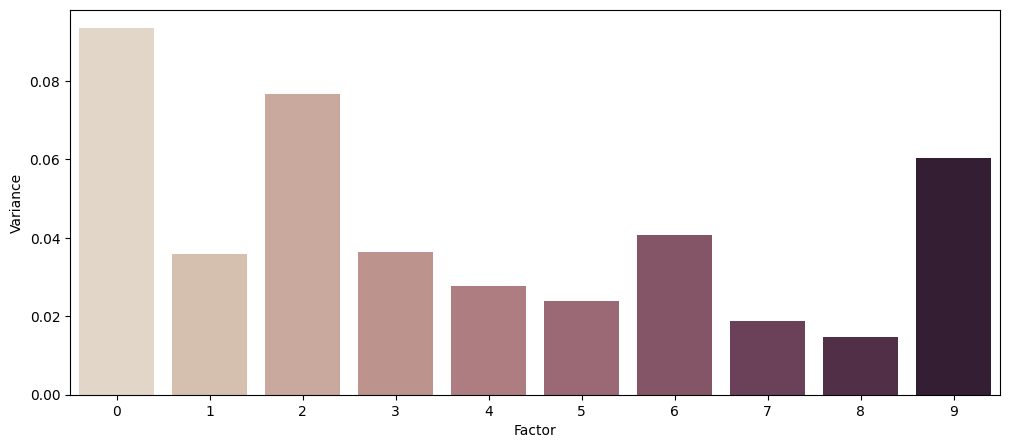

In [13]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(mf.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

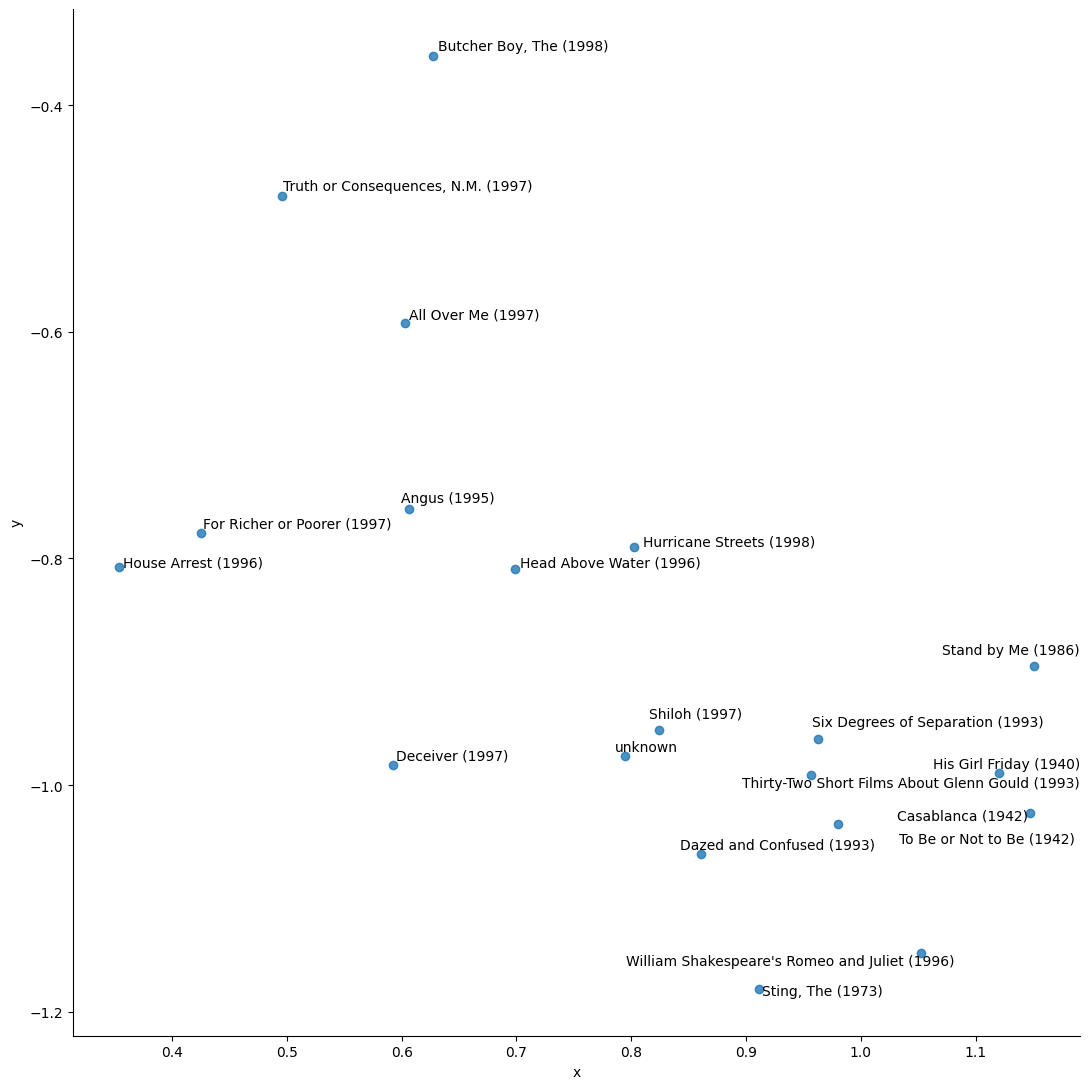

In [14]:
TOP2F = (0, 2)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(mf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=mf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(mf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

### NMF

Below is the variance of each latent dimension.

<ipython-input-15-db6f3dfd6346>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);


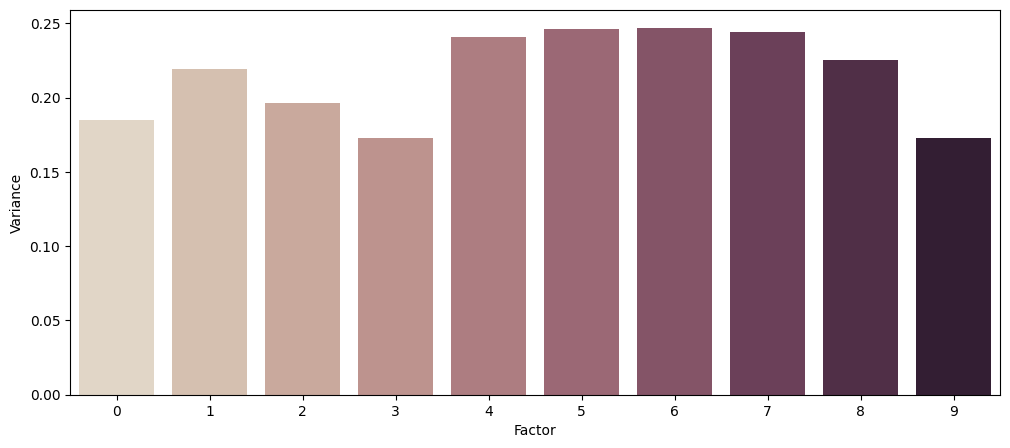

In [15]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(nmf.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

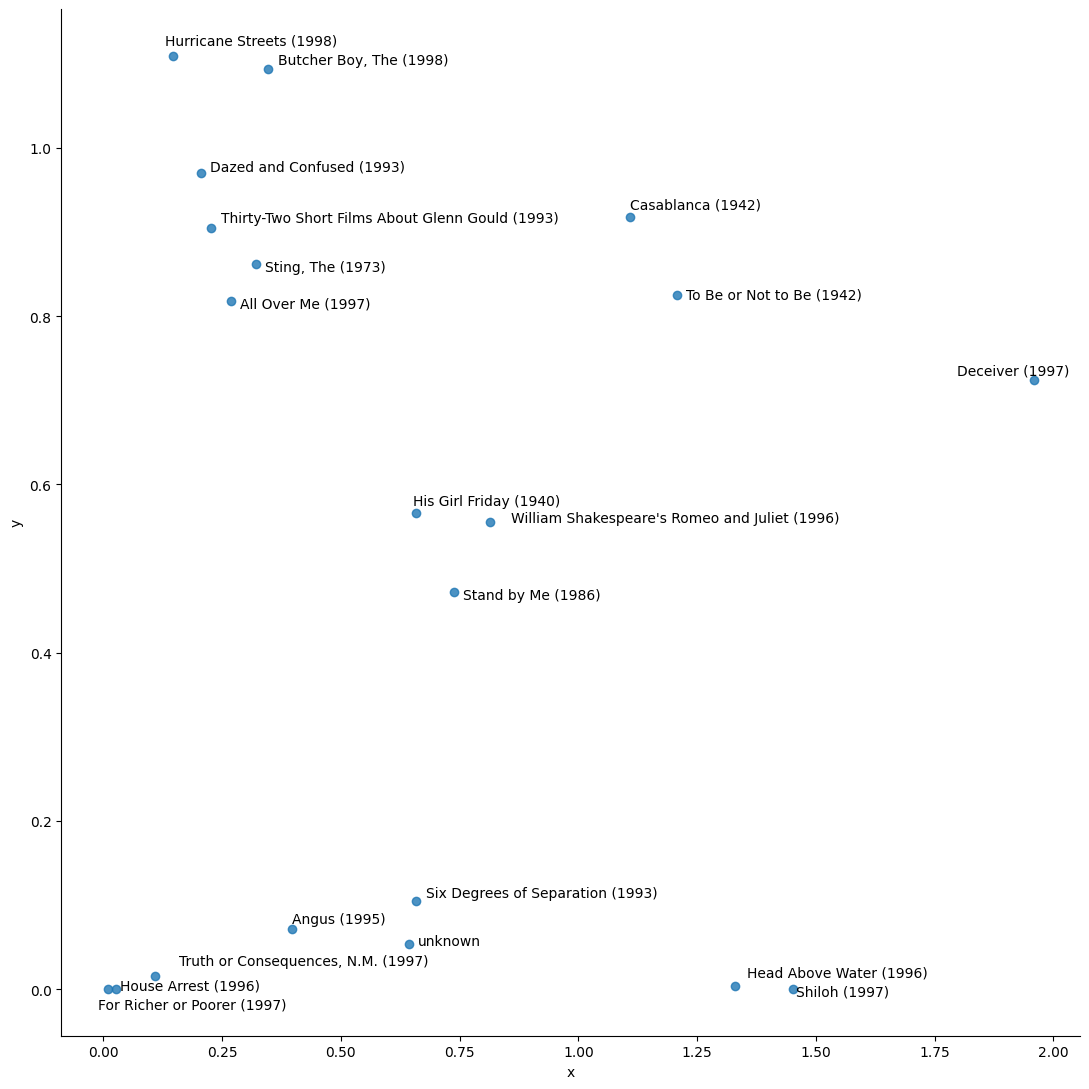

In [16]:
TOP2F = (5, 6)
SAMPLE_SIZE = 20

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(nmf.i_factors.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=nmf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])

sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
item_idx2id = list(nmf.train_set.item_ids)
titles = item_df.loc[[int(item_idx2id[i]) for i in sample_inds]]["Title"].values
adjust_text(
  [plt.text(*sample_df.loc[i].values, titles[i], size=10) for i in range(len(titles))]
);

Let's see what are the top movies (i.e., highest values) of each latent dimension.

In [17]:
item_idx2id = list(nmf.train_set.item_ids)
top_items = {}
for k in range(K):
  top_inds = np.argsort(nmf.i_factors[:, k])[-5:][::-1]
  top_items[f"Factor {k}"] = item_df.loc[[int(item_idx2id[i]) for i in top_inds]]["Title"].values
pd.DataFrame(top_items)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
0,Carpool (1996),Best Men (1997),Bhaji on the Beach (1993),"Garden of Finzi-Contini, The (Giardino dei Fin...",Tough and Deadly (1995),"Boys, Les (1997)",Ruby in Paradise (1993),Deep Rising (1998),City of Industry (1997),Gumby: The Movie (1995)
1,"Good Man in Africa, A (1994)",Paradise Lost: The Child Murders at Robin Hood...,Panther (1995),Kissed (1996),8 Heads in a Duffel Bag (1997),Nénette et Boni (1996),Mina Tannenbaum (1994),Captives (1994),Romper Stomper (1992),Turbulence (1997)
2,"Neon Bible, The (1995)",Angel Baby (1995),Nina Takes a Lover (1994),"Ice Storm, The (1997)",Selena (1997),Ghost in the Shell (Kokaku kidotai) (1995),Harlem (1993),"Baby-Sitters Club, The (1995)",Tetsuo II: Body Hammer (1992),"Man in the Iron Mask, The (1998)"
3,C'est arrivé près de chez vous (1992),Cemetery Man (Dellamorte Dellamore) (1994),Cats Don't Dance (1997),"Low Down Dirty Shame, A (1994)",Love Jones (1997),Grace of My Heart (1996),"Secret Agent, The (1996)",Prisoner of the Mountains (Kavkazsky Plennik) ...,"Boys, Les (1997)",Radioland Murders (1994)
4,Miami Rhapsody (1995),Underground (1995),Until the End of the World (Bis ans Ende der W...,Dunston Checks In (1996),"Little Princess, The (1939)",Stalingrad (1993),"White Balloon, The (1995)",Guilty as Sin (1993),To Live (Huozhe) (1994),Infinity (1996)


For each latent factor, we take the top 100 movies with the highest values for that factor.  We then bin them into their respective genres. This hints at whether there is a relationship or association between latent factors and movie genres.

In [18]:
item_idx2id = list(nmf.train_set.item_ids)
top_genres = {}
for k in range(K):
  top_inds = np.argsort(nmf.i_factors[:, k])[-100:]
  top_items = item_df.loc[[int(item_idx2id[i]) for i in top_inds]]
  top_genres[f"Factor {k}"] = top_items.drop(columns=["Title", "Release Date"]).sum(axis=0)
pd.DataFrame(top_genres)

,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9
Action,18,11,12,17,12,7,4,5,20,15
Adventure,12,4,11,3,5,3,6,2,13,11
Animation,0,1,1,5,3,2,5,0,0,3
Children's,5,3,6,5,5,5,2,2,8,20
Comedy,27,29,31,36,22,32,33,28,24,38
Crime,7,9,5,9,4,3,6,4,9,3
Documentary,3,10,1,3,1,6,4,3,2,3
Drama,39,42,45,43,49,50,55,60,45,30
Fantasy,0,1,1,0,1,1,0,0,1,2
Film-Noir,1,0,0,3,2,1,0,1,0,1


## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37.
3.   Lee, D. D., & Seung, H. S. (2001). Algorithms for non-negative matrix factorization. In Advances in neural information processing systems (pp. 556-562).

